In [1]:
pip install arduino-iot-cloud


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
import traceback
import asyncio
import nest_asyncio
from threading import Thread, Timer
from arduino_iot_cloud import ArduinoCloudClient
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Output, Input
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import time
import os
import signal

# Enable nested asyncio loops
nest_asyncio.apply()

# Device credentials (replace with your actual credentials)
DEVICE_ID = "49a010ea-97bf-4517-a11e-602344034f7b"
SECRET_KEY = "0n1a3jnbPbNsluP4#AI9zKi!V"

# Global dictionary to store the latest values for accelerometer X, Y, and Z
latest_values = {'X': None, 'Y': None, 'Z': None}

# Buffer for the Plotly Dash graph (limit it to 100 points)
BUFFER_SIZE = 100
accelerometer_data = {'x': [], 'y': [], 'z': []}

# Function to update graph data with new accelerometer values
def update_graph_data():
    if latest_values['X'] is not None and latest_values['Y'] is not None and latest_values['Z'] is not None:
        # Append the latest values to the buffer
        if len(accelerometer_data['x']) >= BUFFER_SIZE:
            accelerometer_data['x'].pop(0)
            accelerometer_data['y'].pop(0)
            accelerometer_data['z'].pop(0)

        accelerometer_data['x'].append(latest_values['X'])
        accelerometer_data['y'].append(latest_values['Y'])
        accelerometer_data['z'].append(latest_values['Z'])

# Callbacks for each axis, with added debugging
def on_x_changed(client, value: float) -> None:
    latest_values['X'] = value
    update_graph_data()

def on_y_changed(client, value: float) -> None:
    latest_values['Y'] = value
    update_graph_data()

def on_z_changed(client, value: float) -> None:
    latest_values['Z'] = value
    update_graph_data()

# Asynchronous function to run the Arduino Cloud client
async def run_client():
    while True:
        try:
            client = ArduinoCloudClient(device_id=DEVICE_ID, username=DEVICE_ID, password=SECRET_KEY)
            client.register("x", value=None, on_write=on_x_changed)
            client.register("y", value=None, on_write=on_y_changed)
            client.register("z", value=None, on_write=on_z_changed)

            await client.run(interval=5, backoff=2)
        except Exception as e:
            await asyncio.sleep(5)

# Run the asynchronous function in a new thread
def start_client():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(run_client())

# Start the client in a background thread
thread = Thread(target=start_client)
thread.start()

# Plotly Dash app for real-time accelerometer visualization
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Real-Time Accelerometer Data"),
    dcc.Graph(id='live-graph'),
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0),  # Refresh every second
    html.Button('Capture Image', id='capture-button', n_clicks=0),
    html.Div(id='output-state', children='')
])

# Callback to update the graph in Dash
@app.callback(Output('live-graph', 'figure'),
              [Input('interval-component', 'n_intervals')])
def update_graph(n):
    return {
        'data': [
            go.Scatter(x=list(range(len(accelerometer_data['x']))), y=accelerometer_data['x'], mode='lines+markers', name='X-axis'),
            go.Scatter(x=list(range(len(accelerometer_data['y']))), y=accelerometer_data['y'], mode='lines+markers', name='Y-axis'),
            go.Scatter(x=list(range(len(accelerometer_data['z']))), y=accelerometer_data['z'], mode='lines+markers', name='Z-axis')
        ],
        'layout': go.Layout(title='Live Accelerometer Data', xaxis=dict(title='Time (points)'), yaxis=dict(title='Acceleration (m/s²)'))
    }

# Callback to capture the current graph as an image
@app.callback(
    Output('output-state', 'children'),
    [Input('capture-button', 'n_clicks')]
)
def capture_image(n_clicks):
    if n_clicks > 0:
        # Capture the current state of the graph using matplotlib
        plt.figure(figsize=(10, 6))
        plt.plot(accelerometer_data['x'], label="X")
        plt.plot(accelerometer_data['y'], label="Y")
        plt.plot(accelerometer_data['z'], label="Z")
        plt.legend()
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        plt.savefig(f'accelerometer_data_{timestamp}.png')
        return f'Captured image at {timestamp}'

# Function to stop the Dash server after 1 minute using os module
def stop_dash_server():
    print("Stopping the Dash server after 1 minute...")
    os.kill(os.getpid(), signal.SIGTERM)  # Send the SIGTERM signal to terminate the process

# Schedule the Dash app to stop after 60 seconds (1 minute)
def stop_app_after_one_minute():
    Timer(60, stop_dash_server).start()

if __name__ == '__main__':
    stop_app_after_one_minute()  # Schedule the app to stop after 1 minute
    app.run_server(debug=True)


In [2]:
import sys
import traceback
import asyncio
import nest_asyncio
from threading import Thread
from threading import Thread, Timer
from arduino_iot_cloud import ArduinoCloudClient
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Output, Input
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import time

# Enable nested asyncio loops to allow for the proper handling of asynchronous tasks
nest_asyncio.apply()

# Device credentials (replace with your actual credentials)
DEVICE_ID = "49a010ea-97bf-4517-a11e-602344034f7b"
SECRET_KEY = "0n1a3jnbPbNsluP4#AI9zKi!V"

# Global dictionary to store the latest values for accelerometer X, Y, and Z
latest_values = {
    'X': None,
    'Y': None,
    'Z': None,
}

# Buffer for the Plotly Dash graph (limit it to 100 points)
BUFFER_SIZE = 100
accelerometer_data = {'x': [], 'y': [], 'z': []}

# Function to update graph data with new accelerometer values
def update_graph_data():
    if latest_values['X'] is not None and latest_values['Y'] is not None and latest_values['Z'] is not None:
        # Append the latest values to the buffer
        if len(accelerometer_data['x']) >= BUFFER_SIZE:
            accelerometer_data['x'].pop(0)
            accelerometer_data['y'].pop(0)
            accelerometer_data['z'].pop(0)
        
        accelerometer_data['x'].append(latest_values['X'])
        accelerometer_data['y'].append(latest_values['Y'])
        accelerometer_data['z'].append(latest_values['Z'])

# Callback functions for each axis, with added debugging
def on_x_changed(client, value: float) -> None:
    print(f'DEBUG: New X value: {value} from client: {client}')
    latest_values['X'] = value
    update_graph_data()

def on_y_changed(client, value: float) -> None:
    print(f'DEBUG: New Y value: {value} from client: {client}')
    latest_values['Y'] = value
    update_graph_data()

def on_z_changed(client, value: float) -> None:
    print(f'DEBUG: New Z value: {value} from client: {client}')
    latest_values['Z'] = value
    update_graph_data()

# Asynchronous function to run the Arduino Cloud client, with retries and debugging
async def run_client():
    print("DEBUG: Connecting to Arduino IoT Cloud")

    while True:
        try:
            client = ArduinoCloudClient(device_id=DEVICE_ID, username=DEVICE_ID, password=SECRET_KEY)

            # Register properties from Arduino IoT Cloud
            print("DEBUG: Registering properties")
            client.register("x", value=None, on_write=on_x_changed)
            client.register("y", value=None, on_write=on_y_changed)
            client.register("z", value=None, on_write=on_z_changed)

            print("DEBUG: Properties registered. Starting client loop")
            await client.run(interval=5, backoff=2)
        
        except Exception as e:
            print(f"ERROR: Problem connecting or registering properties: {e}")
            print("DEBUG: Retrying connection in 5 seconds...")
            await asyncio.sleep(5)

# Run the asynchronous function in a new thread
def start_client():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(run_client())

# Start the client in a background thread
thread = Thread(target=start_client)
thread.start()

# Plotly Dash app for real-time accelerometer visualization
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Real-Time Accelerometer Data"),
    dcc.Graph(id='live-graph'),
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0),  # Refresh every second
    html.Button('Capture Image', id='capture-button', n_clicks=0),
    html.Div(id='output-state', children='')
])

# Callback to update the graph in Dash
@app.callback(Output('live-graph', 'figure'),
              [Input('interval-component', 'n_intervals')])
def update_graph(n):
    # Create traces for X, Y, Z accelerometer data
    return {
        'data': [
            go.Scatter(
                x=list(range(len(accelerometer_data['x']))),
                y=accelerometer_data['x'],
                mode='lines+markers',
                name='X-axis'
            ),
            go.Scatter(
                x=list(range(len(accelerometer_data['y']))),
                y=accelerometer_data['y'],
                mode='lines+markers',
                name='Y-axis'
            ),
            go.Scatter(
                x=list(range(len(accelerometer_data['z']))),
                y=accelerometer_data['z'],
                mode='lines+markers',
                name='Z-axis'
            )
        ],
        'layout': go.Layout(
            title='Live Accelerometer Data',
            xaxis=dict(title='Time (points)'),
            yaxis=dict(title='Acceleration (m/s²)')
        )
    }

# Callback to capture the current graph as an image
@app.callback(
    Output('output-state', 'children'),
    [Input('capture-button', 'n_clicks')]
)
def capture_image(n_clicks):
    if n_clicks > 0:
        # Capture the current state of the graph using matplotlib (for simplicity)
        plt.figure(figsize=(10, 6))
        plt.plot(accelerometer_data['x'], label="X")
        plt.plot(accelerometer_data['y'], label="Y")
        plt.plot(accelerometer_data['z'], label="Z")
        plt.legend()
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        plt.savefig(f'accelerometer_data_{timestamp}.png')
        return f'Captured image at {timestamp}'


if __name__ == '__main__':
    app.run_server(debug=True)


/var/folders/s1/_9n_hw1n0xddhcntyvxyd4h40000gq/T/ipykernel_40730/3151249646.py:9: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/var/folders/s1/_9n_hw1n0xddhcntyvxyd4h40000gq/T/ipykernel_40730/3151249646.py:10: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


DEBUG: Connecting to Arduino IoT Cloud
DEBUG: Registering properties
DEBUG: Properties registered. Starting client loop


ERROR:root:task: connection_task raised exception: .
ERROR:root:task: discovery raised exception: .


DEBUG: New X value: -0.0202178955078125 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New Y value: -0.01007080078125 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New Z value: -1.0039825439453125 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New X value: -0.020294189453125 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New Y value: -0.0123443603515625 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New Z value: -1.0048370361328125 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New X value: -0.0211639404296875 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New Y value: -0.0096588134765625 from client: <arduino_iot_cloud.ucloud.ArduinoCloudClient object at 0x117d62290>
DEBUG: New Z value: -1.004852294921

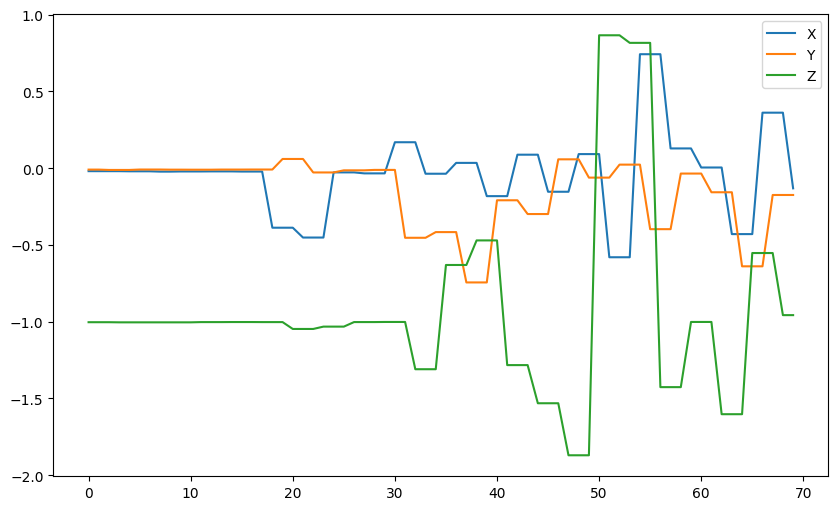

In [6]:
def create_smooth_dash_graph(app, data_source, update_interval=1000, buffer_size=100):
    buffer = {
        'x': [],
        'y': [],
        'z': []
    }

    # Define the layout of the app
    app.layout = html.Div([
        html.H1("Real-Time Data"),
        dcc.Graph(id='live-graph'),
        dcc.Interval(id='interval-component', interval=update_interval, n_intervals=0),
    ])

    # Function to update the buffer with new data
    def update_data(new_data):
        if len(buffer['x']) >= buffer_size:
            buffer['x'].pop(0)
            buffer['y'].pop(0)
            buffer['z'].pop(0)
        buffer['x'].append(new_data['x'])
        buffer['y'].append(new_data['y'])
        buffer['z'].append(new_data['z'])

    # Plotly Dash callback to update the graph
    @app.callback(Output('live-graph', 'figure'),
                  [Input('interval-component', 'n_intervals')])
    def update_graph(n):
        return {
            'data': [
                go.Scatter(x=list(range(len(buffer['x']))), y=buffer['x'], mode='lines+markers', name='X-axis'),
                go.Scatter(x=list(range(len(buffer['y']))), y=buffer['y'], mode='lines+markers', name='Y-axis'),
                go.Scatter(x=list(range(len(buffer['z']))), y=buffer['z'], mode='lines+markers', name='Z-axis')
            ],
            'layout': go.Layout(
                title='Live Data',
                xaxis=dict(title='Time (points)'),
                yaxis=dict(title='Value')
            )
        }

    # Start the app
    return app
